In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vcf
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
from qqman import qqman

In [2]:
df = pd.read_table('gwas.phen', sep='\s+', header=None)
phen_values = df[2].to_numpy()
phen_samples = df[0].to_numpy()

vcf_reader = vcf.Reader(filename="gwas.vcf.gz")
vcf_samples = []

for record in vcf_reader:
    for sample in record.samples:
        vcf_samples.append(sample.sample)
    break

In [3]:
vcf_reader = vcf.Reader(filename="gwas.vcf.gz")
Xj = []

for record in tqdm(vcf_reader):
    snp = []
    for sample in record.samples:
        gt_alleles = sample.gt_alleles
        snp.append(int(gt_alleles[0] != '0') + int(gt_alleles[1] != '0')) #(gt_alleles[0] != 0) + ... # 0|2 -> 1
    Xj.append(snp)

917845it [10:34, 1445.84it/s]


In [4]:
organized_phen_samples = []
organized_phen_values = []
for vSample in vcf_samples:
    for i in range(len(phen_samples)):
        if vSample == phen_samples[i]:
            organized_phen_samples.append(phen_samples[i])
            organized_phen_values.append(phen_values[i])


Our Model: Y = alpha_j + beta_j * X_j + epsilon_j

In [5]:
class LinearRegressionModel:
    def init(self, alphas, xs, Ys):
        assert(len(alphas) == len(xs) == len(Ys))
        self.alphas = alphas
        self.xs = xs
        self.Ys = Ys
    def fit(self):
        sum_squared_x = np.sum(self.xs**2)
        sum_x_squared = np.sum(self.xs)**2
        sum_xy = np.sum(self.xs*self.Ys)
        sum_x_sum_y = np.sum(self.xs)*np.sum(self.Ys)
        n = len(self.xs)

        Beta = (sum_xy - (sum_x_sum_y / n)) / (sum_squared_x - (sum_x_squared / n))        
        return Beta


In [6]:
#Add column of ones before values
def add_column_ones(x):
    return np.append(np.atleast_2d(np.ones(len(x))).T, np.atleast_2d(x).T, axis=1)

# Any model we use needs to be used in a function like this
# This one uses statsmodels
# Must return Beta, PValue
def runLinearModel(x, y):
    X = add_column_ones(x)
    model = sm.OLS(y, X)
    results = model.fit()
    return results.params[1], results.pvalues[1]


In [7]:
class GWAS:
    def init(self, linearFunc, gts, pts):
        self.gts = gts
        self.linearFunc = linearFunc
        self.pts = pts
    def get_p_values(self):
        #row is snp
        #column is sample
        pValues = []
        for snp in tqdm(self.gts):
            beta, pValue = self.linearFunc(self.pts, snp)
            pValues.append(pValue)
        return pValues

In [8]:
gwas = GWAS()
gwas.init(runLinearModel, Xj, organized_phen_values)
p_values = gwas.get_p_values()


100%|██████████| 917845/917845 [03:19<00:00, 4597.40it/s]


In [15]:
vcf_reader = vcf.Reader(filename="gwas.vcf.gz")
df = pd.DataFrame(columns=['BP','CHR','P', 'SNP'])
BP = []
CHR = []
SNP = []

for record in tqdm(vcf_reader):
    # df1 = pd.DataFrame({'BP':[record.POS],'CHR':[record.CHROM],'P':[p_values[index]],'SNP':[record.ID]})
    # df = pd.concat([df,df1])
    BP.append(record.POS)
    CHR.append(record.CHROM)   
    SNP.append(record.ID)


917845it [11:44, 1302.16it/s]


In [16]:
def QQPlot(pvals):
    # Sort the observed p-values
    pvals.sort()
    # Generate numbers from a uniform distribution
    n = len(pvals)
    a = .375 if n<=10 else .5
    unif = (np.arange(n) + 1 - a)/(n + 1 - 2*a)

    # Make a QQ plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(-1*np.log10(unif), -1*np.log10(pvals), s=5, color="black")
    ax.plot([0, 6], [0,6])
    # ax.set_xlim(left=0, right=3)
    # ax.set_ylim(bottom=0, top=max(-1*np.log10([item for item in pvals if item >0])))
    ax.set_xlabel("Expected -log10(P)")
    ax.set_ylabel("Observed -log10(P)")

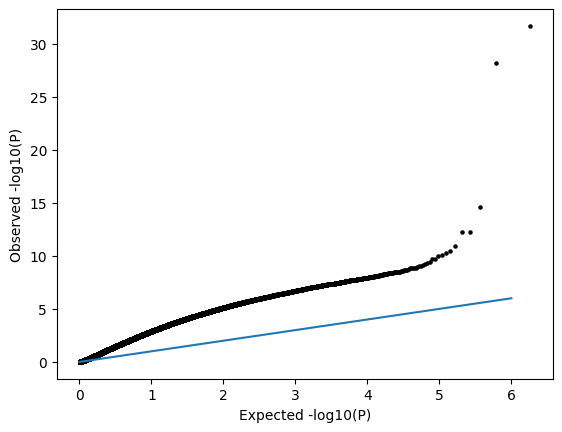

In [17]:
QQPlot(np.sort(p_values))

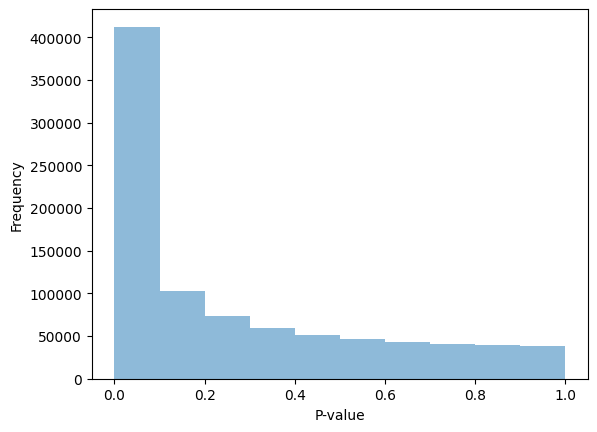

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(p_values, alpha=0.5, bins=np.arange(0, 1.05, 0.1))
ax.set_xlabel("P-value")
ax.set_ylabel("Frequency")

In [33]:
df = pd.DataFrame({'CHR':[int(c) for c in CHR],'BP':BP,'P':p_values, 'SNP':SNP})
df

,CHR,BP,P,SNP
0,10,98087,0.109734,rs11252127
1,10,111955,0.363471,rs7909677
2,10,126070,0.504264,rs11591988
3,10,134767,0.547052,rs12768206
4,10,135656,0.142948,rs10904561
...,...,...,...,...
917840,9,141018423,0.000822,rs9777369
917841,9,141025328,0.034320,rs11137376
917842,9,141026318,0.001052,rs17583562
917843,9,141027939,0.319168,rs11137379


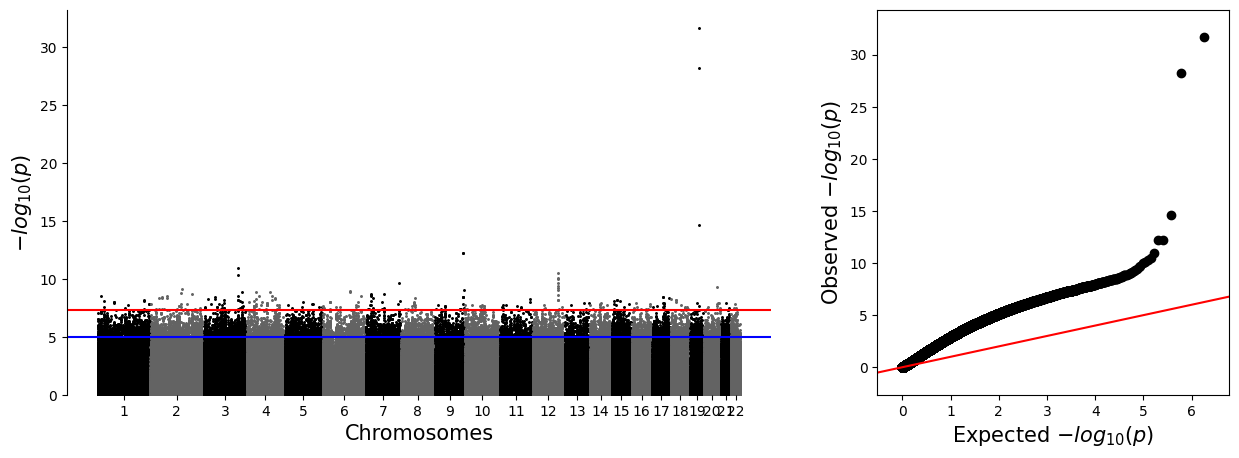

In [34]:
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
fig.set_size_inches((15, 5))
qqman.manhattan(df, ax=ax0)
qqman.qqplot(df, ax=ax1)